# Taitanic

## 1. Importing the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", message="X has feature names, but .*")


## 2. Loading the Data

In [2]:
data_train = pd.read_csv('Data\\train.csv')
data_test = pd.read_csv('Data\\test.csv')


In [3]:
print(data_train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [4]:
print(data_test.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


## 3. Data Visulization

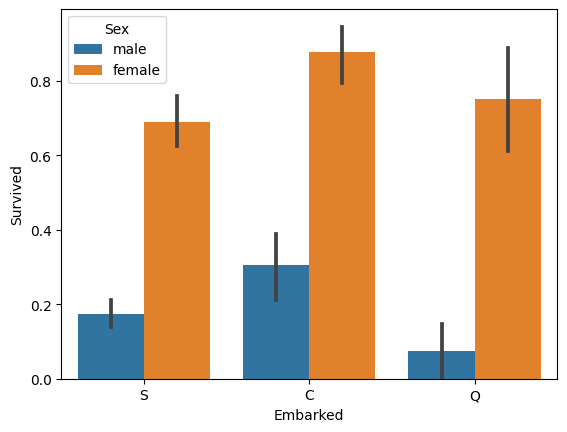

In [5]:
sns.barplot(x='Embarked', y='Survived', hue='Sex', data=data_train)
plt.show()

## 4. Data Cleaning and Transformation

In [6]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)



## 5. Encoding the Data

In [7]:

from sklearn import preprocessing

def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)




## 6. Splitting the data into Training and Test sets


In [8]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis =1)
y_all = data_train['Survived']

num_test = 0.20

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = num_test, random_state = 23)

## 7. Fine Tuning Algorithms

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9],
               'max_features': ['sqrt'],  # Set max_features to 'sqrt'
               'criterion': ['entropy', 'gini'],
               'max_depth': [2, 3, 5, 10],
               'min_samples_split': [2, 3, 5],
               'min_samples_leaf': [1, 5, 8]
               }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=5,
                       n_estimators=9)

In [10]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8100558659217877


## 8. Cross Validate with KFold

In [11]:
from sklearn.model_selection import KFold

def run_kfold(clf):
    kf = KFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X_all):
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))

    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome))

run_kfold(clf)

Fold 1 accuracy: 0.8444444444444444
Fold 2 accuracy: 0.8764044943820225
Fold 3 accuracy: 0.797752808988764
Fold 4 accuracy: 0.8651685393258427
Fold 5 accuracy: 0.8202247191011236
Fold 6 accuracy: 0.8089887640449438
Fold 7 accuracy: 0.7865168539325843
Fold 8 accuracy: 0.7865168539325843
Fold 9 accuracy: 0.8651685393258427
Fold 10 accuracy: 0.7865168539325843
Mean Accuracy: 0.8237702871410736


## 9. Prediction on the test set 

In [12]:
ids = data_test['PassengerId']  # Extract 'PassengerId' column
data_test.drop('PassengerId', axis=1, inplace=True)  # Drop 'PassengerId' column from data_test
predictions = clf.predict(data_test)  # Make predictions
output = pd.DataFrame({'PassengerId': ids, 'Survived': predictions})  # Create DataFrame with 'PassengerId' and predictions
output.head()  # Display first few rows of the output DataFrame

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
